# Import Dependencies

In [1]:
import os 
import shutil 
import json 
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy import ndimage as ndi 
from skimage.filters import gabor_kernel 
from tqdm.notebook import tqdm

from preprocessing.image_conversion import resize_reference_image
from clustering import *

# Dataset Creation

In [2]:
def read_fragments(fragments_dir: str, denoise: bool = True, max_dim: tuple[int, int] = (200, 200)) -> (np.array, dict): 
    fragments = []
    fragments_reading_order = {}
    
    filenames = os.listdir(fragments_dir)
    for idx, filename in tqdm(enumerate(filenames), desc="Reading fragments", total=len(filenames)): 
        fragments_reading_order[filename] = idx 
        fragment = cv.imread(os.path.join(fragments_dir, filename), cv.IMREAD_UNCHANGED)
        fragment = cv.cvtColor(fragment, cv.COLOR_BGR2HSV)
        fragment = cv.resize(fragment, max_dim[::-1]) # invert from (w, h) to (h, w) to match numpy's standard 
        
        if denoise: 
            fragment = cv.fastNlMeansDenoisingColored(fragment)
            
        fragments.append(fragment)

    return np.array(fragments), fragments_reading_order

def read_references(references_dir: str, denoise: bool = True, max_dim: tuple[int, int] = (200, 200)) -> (list[np.array], list[int]): 
    references = []
    references_ids = []
    
    filenames = os.listdir(references_dir)
    for filename in tqdm(filenames, desc="Reading references", total=len(filenames)): 
        reference = cv.imread(os.path.join(references_dir, filename), cv.IMREAD_UNCHANGED)
        reference = cv.cvtColor(reference, cv.COLOR_BGR2HSV)
        reference = resize_reference_image(reference, max_dim[0])
        
        if denoise: 
            reference = cv.fastNlMeansDenoisingColored(reference)
            
        references.append(reference)
        references_ids.append(int(filename.split(".")[1]))

    return references, references_ids

In [3]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

def compute_similarity_matrix(feats):
    n_images = len(feats)
    similarity_matrix = np.zeros((n_images, n_images))
    for i in range(n_images):
        for j in range(n_images):
            similarity_matrix[i, j] = np.linalg.norm(feats[i] - feats[j])
    return similarity_matrix

# Prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4.0 * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

In [12]:
def extract_reference_working_region(reference_image: np.array, threshold: int = 5, padding: int = 1) -> np.array: 
    height, width, _ = reference_image.shape
    alpha_channel = np.ones((height, width), dtype=reference_image.dtype) * 255  # Fully opaque alpha channel
    
    # Combine RGB image with alpha channel to get RGBA image
    rgba_image = np.dstack((reference_image, alpha_channel))
    
    # Step 4: Create a new image with transparent padding
    new_height = height + threshold + threshold
    new_width = width + threshold + threshold
    transparent_background = np.zeros((new_height, new_width, 4), dtype=reference_image.dtype)  # Fully transparent RGBA image
    
    # Step 5: Place the original RGBA image onto the transparent background
    transparent_background[padding:padding+height, padding:padding+width] = rgba_image
    return filter_working_region(extract_working_region(transparent_background, threshold=threshold))


# Barbara

In [111]:
def minmax_norm(values: np.array) -> np.array:
    min_val = np.min(values)
    max_val = np.max(values)
    return (values - min_val) / (max_val - min_val)
 

def create_composite_image(fragments: np.array, image_size: tuple[int, int, int]) -> np.array: 
    width, height, channels = image_size 
    # create a blank canvas for the composite image
    composite_image = np.zeros(image_size, dtype=np.uint8)
    composite_area = width * height 
    n_fragments = len(fragments) 
    fragment_size = int(np.sqrt(composite_area / n_fragments))

    x = 0
    y = 0
    for i in range(n_fragments): 
        x_offset = x * fragment_size
        y_offset = y * fragment_size
        size = (fragment_size, fragment_size)

        x += 1
        
        area_to_cover = composite_image[x_offset:x_offset + fragment_size, y_offset:y_offset + fragment_size].shape[:2]
        # resize the fragment if it goes over outbounds the width or the height
        if area_to_cover[0] < fragment_size:
            # increment row and reset col where to insert the fragment
            x = 0
            y += 1
            if area_to_cover[0] == 0:
                x_offset = x * fragment_size
                y_offset = y * fragment_size
            else: 
                size = (area_to_cover[0], fragment_size)
        elif area_to_cover[1] < fragment_size:
            size = (fragment_size, area_to_cover[1])
    
        # resize the fragment it it goes over outbounds the width or the height
       
        res_fragment = cv.resize(fragments[i], size[::-1])
        composite_image[x_offset:x_offset + fragment_size, y_offset:y_offset + fragment_size] = res_fragment

    # Handle remaining area if the fragments do not perfectly fill the image
    # Find the bounding box around non-black pixels
    non_black_pixels = np.argwhere(composite_image.sum(axis=2) > 0)
    min_y, min_x = np.min(non_black_pixels, axis=0)
    max_y, max_x = np.max(non_black_pixels, axis=0)
    
    # Crop the composite image to the bounding box
    cropped_composite_image = composite_image[min_y:max_y+1, min_x:max_x+1]
    # Resize the cropped composite image to the original width and height
    return cv.resize(cropped_composite_image, (width, height))


def compute_SIFT_matches(reference_image: np.array, composite_image: np.array) -> tuple[float, int]:
    sift = cv.SIFT_create()
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck = False)

    composite_image = cv.resize(composite_image, reference_image.shape[:2][::-1])
    
    plt.subplot(1, 2, 1)
    plt.title("Reference Image")
    plt.imshow(reference_image)
    plt.subplot(1, 2, 2)
    plt.title("Composite Image")
    plt.imshow(composite_image)
    plt.show()

    composite_image_keypoints, composite_image_descriptor = sift.detectAndCompute(composite_image, None)
    reference_keypoints, reference_descriptor = sift.detectAndCompute(reference_image, None)

    # Perform the matching between the SIFT descriptors of the fragment image and the reference image
    matches = bf.match(composite_image_descriptor, reference_descriptor)
    distances = [match.distance for match in matches]
    n_distances = len(distances)

    if n_distances:
        matches_median = np.median(distances)
        if not np.isnan(matches_median):
            return matches_median, n_distances
    return np.nan, n_distances


def choose_IN_cluster(reference_image: np.array, reference_id: int, root_dir: str, fragments: np.array, fragments_reading_order: dict, 
                      image_size: tuple[int, int, int], color_weights: list[int], choice_weights: list[int]) -> (str, str, float, float):
    
    reference_color_histogram = cv.calcHist([reference_image], [0, 1, 2], None, (8, 8, 8), [0, 256, 0, 256, 0, 256])
    cv.normalize(reference_color_histogram, reference_color_histogram, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    candidate_clusters = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    scores = []
    recalls = []
    distances = []
    matches = []
    histograms = []
    n_fragments = [] 
    total_fragments = len(fragments) 
    
    for candidate_cluster in candidate_clusters: 
        # filter out only the fragments contained in this specific cluster directory 
        cluster_indexes = [fragments_reading_order[filename] for filename in os.listdir(os.path.join(root_dir, candidate_cluster))]
        cluster_fragments = fragments[cluster_indexes] 

        composite_image = create_composite_image(cluster_fragments, image_size)
        
        composite_color_histogram = cv.calcHist([composite_image], [0, 1, 2], None, (8, 8, 8), [0, 256, 0, 256, 0, 256])
        cv.normalize(composite_color_histogram, composite_color_histogram, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
        median_distance, n_matches = compute_SIFT_matches(reference_image, composite_image)
        
        distances.append(median_distance)
        matches.append(n_matches) 
        histograms.append(composite_color_histogram)
        n_fragments.append(len(cluster_fragments))

    max_distance = max(distances)
    max_matches = max(matches)

    print(f"Max distance: {max_distance} - Max N. Matches: {max_matches}")
                           
    for i in range(len(candidate_clusters)): 
        color_correlation = np.abs(cv.compareHist(reference_color_histogram, histograms[i], cv.HISTCMP_CORREL))
        color_intersection = cv.compareHist(reference_color_histogram, histograms[i], cv.HISTCMP_INTERSECT) / np.sum(histograms[i])
        
        color_similarity = -(1 - (color_weights[0] * color_correlation + color_weights[1] * color_intersection))

        norm_distance = distances[i] / max_distance
        norm_matches = matches[i] / max_matches
        norm_n_fragments = n_fragments[i] / total_fragments
        
        score = choice_weights[0] * (norm_matches - norm_distance) + choice_weights[1] * color_similarity + choice_weights[2] * norm_n_fragments
        recall = recall_in_out_clusters(reference_id, root_dir, [candidate_clusters[i]])
        recalls.append(recall)
        scores.append(score)

        print(f"Cluster: {candidate_clusters[i]} - Color Similarity: {color_similarity:.2f} - Distance: {distances[i]} - N. Matches: {matches[i]} - Score: {score:.2f} - Recall: {recall:.2f}")

    # Return the cluster directory with the highest score
    max_score_idx = np.argmax(scores)
    max_recall_idx = np.argmax(recalls)

    return candidate_clusters[max_score_idx], candidate_clusters[max_recall_idx], recalls[max_score_idx], recalls[max_recall_idx]


def find_elbow_point(values):
  norm_values = (values - values.min()) / (values.max() - values.min())

  # Calculate distances to the line formed by the first and last points
  n_points = len(norm_values)
  all_coords = np.vstack((range(n_points), norm_values)).T
  line_vec = all_coords[-1] - all_coords[0]
  line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
  vec_from_first = all_coords - all_coords[0]
  scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
  vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
  vec_to_line = vec_from_first - vec_from_first_parallel
  distances = np.sqrt(np.sum(vec_to_line**2, axis=1))

  # Find the elbow point
  elbow_idx = np.argmax(distances)
  elbow_value = values[elbow_idx]

  plt.figure()
  plt.plot(range(n_points), norm_values, 'b-', marker='o')
  plt.plot([0, n_points - 1], [norm_values[0], norm_values[-1]], 'r--')
  plt.plot(elbow_idx, norm_values[elbow_idx], 'ro')
  plt.title('Elbow Point Detection')
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.show()
  
  print(f"Elbow idx: {elbow_idx} - Elbow value: {elbow_value}")
    
  return elbow_idx, elbow_value


def recall_in_cluster(reference_image_id: int, reference_cluster_dir: str, data_dir: str) -> float:
    """
    Calculate the recall of the reference image within the reference cluster directory.
    
    Recall measures the proportion of relevant items that are retrieved.
    
    Args:
        reference_image_id (int): The ID of the reference image.
        reference_cluster_dir (str): The directory containing the reference cluster images.
        data_dir (str): The directory containing the dataset images.
    
    Returns:
        float: The recall value.
    """
    tp = 0
    tp_filenames = set()
    
    # Count true positives in the reference cluster directory
    for filename in os.listdir(reference_cluster_dir):
        if filename.split(".")[1] == str(reference_image_id):
            tp += 1
            tp_filenames.add(filename)
    
    # Count false negatives in the data directory
    fn = sum(1 for filename in os.listdir(data_dir) if filename.split(".")[1] == str(reference_image_id) and filename not in tp_filenames)
    
    total = tp + fn
    
    return tp / total if total else 0.0

# Clustering

In [101]:
fragments_dir = "data"
references_dir = "references"
max_fragments_dims = (100, 100) 
max_references_dim = (800, 800)
references_working_region_threshold = 20

output_dir = "clusters"
in_clusters_dir = "in_clusters"
image_size = (1000, 1000, 3)
seed = 42 

choice_weights = [0.5, 0.5, 0.3] 
color_weights = [0.5, 0.5]

In [9]:
fragments, fragments_reading_order = read_fragments(fragments_dir, max_dim=max_fragments_dims)
references, references_ids = read_references(references_dir, max_dim=max_references_dim)

Reading fragments:   0%|          | 0/2084 [00:00<?, ?it/s]

Reading references:   0%|          | 0/26 [00:00<?, ?it/s]

In [14]:
fragments_paths = [os.path.join(fragments_dir, filename) for filename in fragments_reading_order.keys()]

In [10]:
color_histograms = compute_color_histograms(fragments, flatten=False)
n_fragments = len(fragments)
feats = []
for i in tqdm(range(len(color_histograms)), desc="Extracting texture features", total=len(color_histograms)):
      fragment = fragments[i]
      fragment = cv.cvtColor(fragment, cv.COLOR_HSV2BGR)
      fragment = cv.cvtColor(fragment, cv.COLOR_BGR2GRAY)
      feats.append(compute_feats(fragment, kernels))

# normalize texture features
feats = np.array(feats)
normalized_feats = minmax_norm(feats)

Computing color histograms:   0%|          | 0/2084 [00:00<?, ?it/s]

Extracting texture features:   0%|          | 0/2084 [00:00<?, ?it/s]

Iteration 1 out of 26 - Reference ID 1
---------------------------------------------


Creating dataset for Reference 1:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

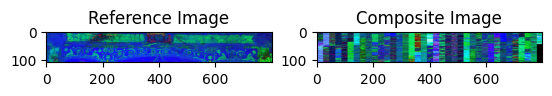

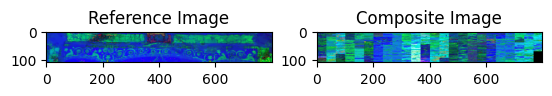

Max distance: 2318.0 - Max N. Matches: 956
Cluster: cluster_0 - Color Similarity: -0.84 - Distance: 2313.0 - N. Matches: 956 - Score: -0.20 - Recall: 0.54
Cluster: cluster_1 - Color Similarity: -0.82 - Distance: 2318.0 - N. Matches: 821 - Score: -0.39 - Recall: 0.46
Recall: 0.54


Refining IN Cluster for Reference ID 1:   0%|          | 0/1493 [00:00<?, ?it/s]

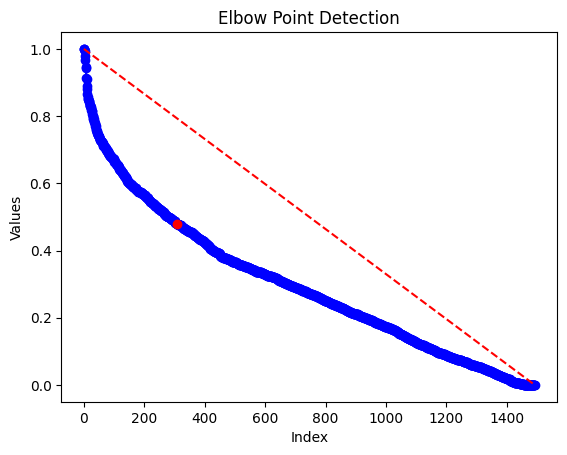

Elbow idx: 307 - Elbow value: 0.47979650925719136


Copying fragments to refined IN-Cluster dir for Reference ID 1:   0%|          | 0/308 [00:00<?, ?it/s]

Iteration 2 out of 26 - Reference ID 10
---------------------------------------------


Creating dataset for Reference 10:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

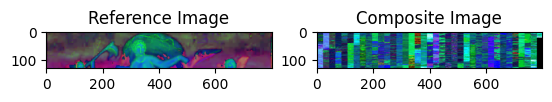

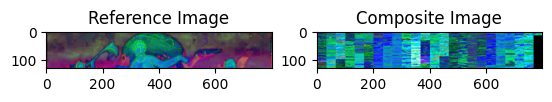

Max distance: 2538.0 - Max N. Matches: 1180
Cluster: cluster_0 - Color Similarity: -0.40 - Distance: 2538.0 - N. Matches: 1180 - Score: 0.01 - Recall: 0.94
Cluster: cluster_1 - Color Similarity: -0.40 - Distance: 2506.0 - N. Matches: 1033 - Score: -0.17 - Recall: 0.06
Recall: 0.94


Refining IN Cluster for Reference ID 10:   0%|          | 0/1483 [00:00<?, ?it/s]

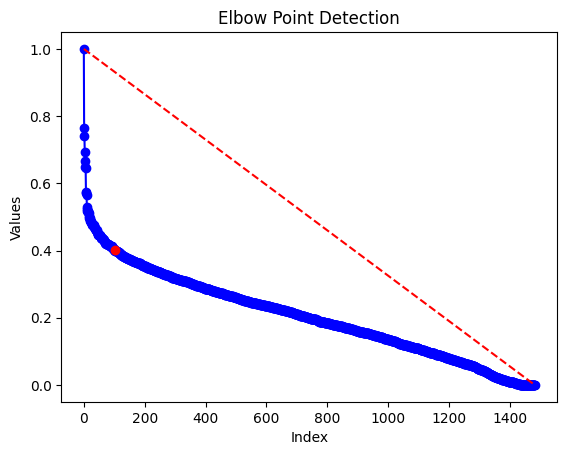

Elbow idx: 102 - Elbow value: 0.30713062260721924


Copying fragments to refined IN-Cluster dir for Reference ID 10:   0%|          | 0/103 [00:00<?, ?it/s]

Iteration 3 out of 26 - Reference ID 11
---------------------------------------------


Creating dataset for Reference 11:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

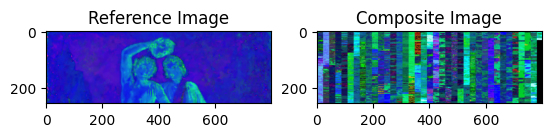

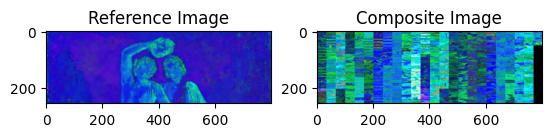

Max distance: 2582.5 - Max N. Matches: 2212
Cluster: cluster_0 - Color Similarity: -0.54 - Distance: 2512.0 - N. Matches: 2212 - Score: -0.04 - Recall: 0.93
Cluster: cluster_1 - Color Similarity: -0.63 - Distance: 2582.5 - N. Matches: 2018 - Score: -0.27 - Recall: 0.07
Recall: 0.93


Refining IN Cluster for Reference ID 11:   0%|          | 0/1481 [00:00<?, ?it/s]

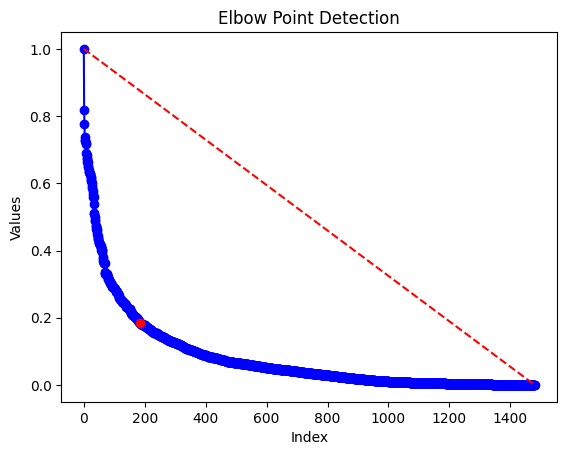

Elbow idx: 185 - Elbow value: 0.17368745793604468


Copying fragments to refined IN-Cluster dir for Reference ID 11:   0%|          | 0/186 [00:00<?, ?it/s]

Iteration 4 out of 26 - Reference ID 12
---------------------------------------------


Creating dataset for Reference 12:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

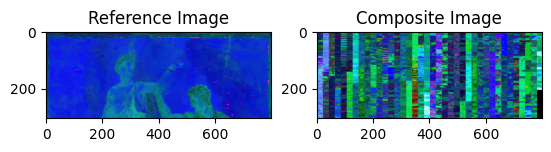

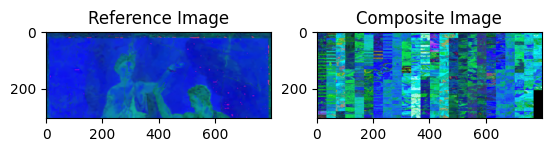

Max distance: 2837.0 - Max N. Matches: 2713
Cluster: cluster_0 - Color Similarity: -0.84 - Distance: 2825.0 - N. Matches: 2713 - Score: -0.21 - Recall: 1.00
Cluster: cluster_1 - Color Similarity: -0.86 - Distance: 2837.0 - N. Matches: 2457 - Score: -0.39 - Recall: 0.00
Recall: 1.00


Refining IN Cluster for Reference ID 12:   0%|          | 0/1469 [00:00<?, ?it/s]

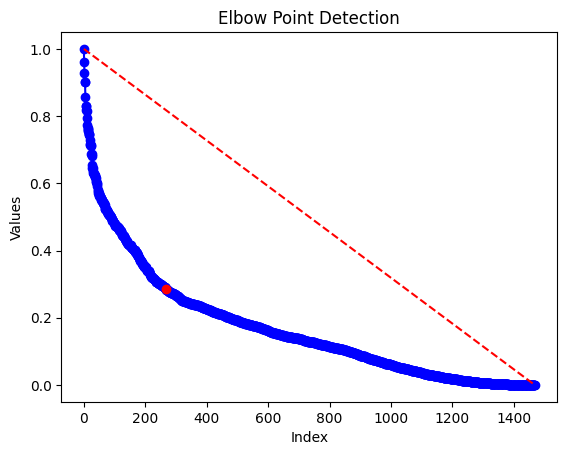

Elbow idx: 267 - Elbow value: 0.17316988955211923


Copying fragments to refined IN-Cluster dir for Reference ID 12:   0%|          | 0/268 [00:00<?, ?it/s]

Iteration 5 out of 26 - Reference ID 13
---------------------------------------------


Creating dataset for Reference 13:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

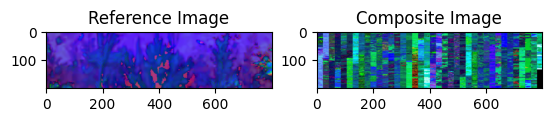

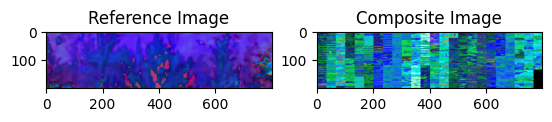

Max distance: 2731.0 - Max N. Matches: 1740
Cluster: cluster_0 - Color Similarity: -0.15 - Distance: 2703.0 - N. Matches: 1740 - Score: 0.14 - Recall: 0.88
Cluster: cluster_1 - Color Similarity: -0.10 - Distance: 2731.0 - N. Matches: 1713 - Score: 0.03 - Recall: 0.12
Recall: 0.88


Refining IN Cluster for Reference ID 13:   0%|          | 0/1469 [00:00<?, ?it/s]

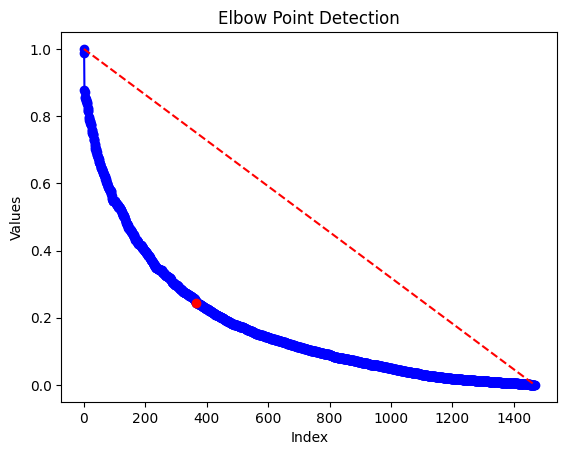

Elbow idx: 366 - Elbow value: 0.23145145742495093


Copying fragments to refined IN-Cluster dir for Reference ID 13:   0%|          | 0/367 [00:00<?, ?it/s]

Iteration 6 out of 26 - Reference ID 14
---------------------------------------------


Creating dataset for Reference 14:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

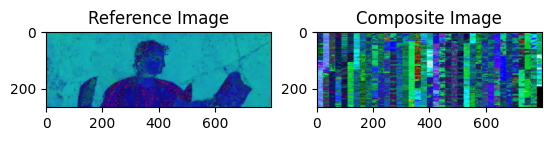

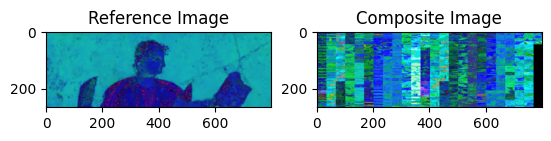

Max distance: 2599.0 - Max N. Matches: 2358
Cluster: cluster_0 - Color Similarity: -0.79 - Distance: 2530.5 - N. Matches: 2358 - Score: -0.17 - Recall: 1.00
Cluster: cluster_1 - Color Similarity: -0.94 - Distance: 2599.0 - N. Matches: 2186 - Score: -0.42 - Recall: 0.00
Recall: 1.00


Refining IN Cluster for Reference ID 14:   0%|          | 0/1505 [00:00<?, ?it/s]

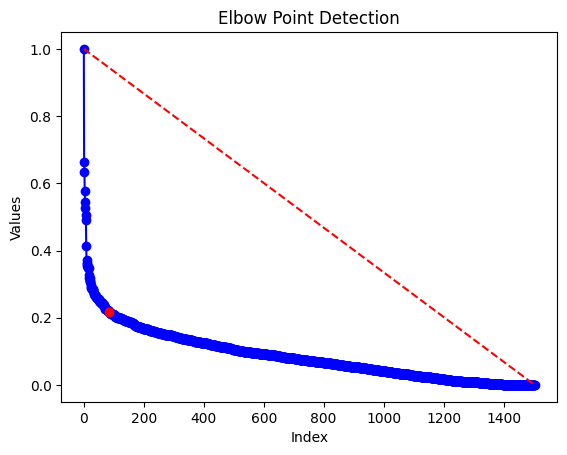

Elbow idx: 85 - Elbow value: 0.11273847756342414


Copying fragments to refined IN-Cluster dir for Reference ID 14:   0%|          | 0/86 [00:00<?, ?it/s]

Iteration 7 out of 26 - Reference ID 15
---------------------------------------------


Creating dataset for Reference 15:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

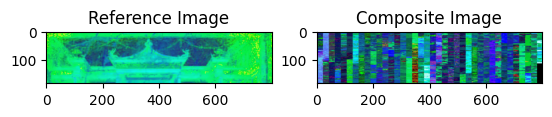

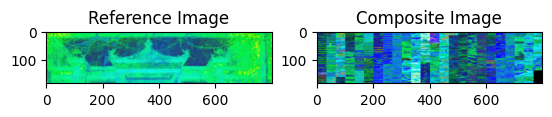

Max distance: 2409.0 - Max N. Matches: 1658
Cluster: cluster_0 - Color Similarity: -0.69 - Distance: 2409.0 - N. Matches: 1658 - Score: -0.13 - Recall: 0.59
Cluster: cluster_1 - Color Similarity: -0.77 - Distance: 2399.0 - N. Matches: 1502 - Score: -0.34 - Recall: 0.41
Recall: 0.59


Refining IN Cluster for Reference ID 15:   0%|          | 0/1467 [00:00<?, ?it/s]

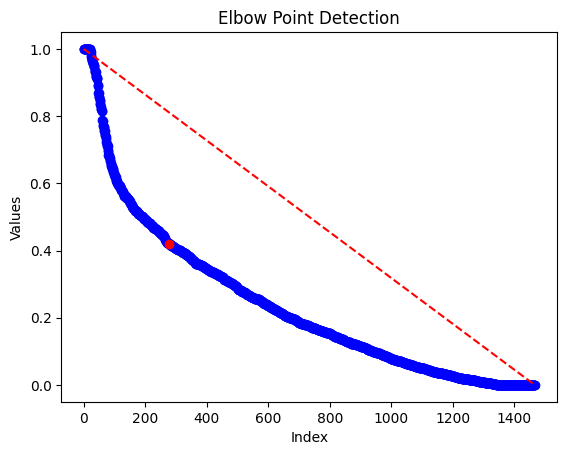

Elbow idx: 278 - Elbow value: 0.4185311024171005


Copying fragments to refined IN-Cluster dir for Reference ID 15:   0%|          | 0/279 [00:00<?, ?it/s]

Iteration 8 out of 26 - Reference ID 16
---------------------------------------------


Creating dataset for Reference 16:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

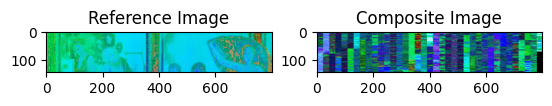

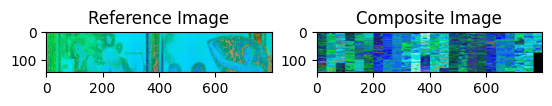

Max distance: 2419.0 - Max N. Matches: 1321
Cluster: cluster_0 - Color Similarity: -0.60 - Distance: 2419.0 - N. Matches: 1321 - Score: -0.08 - Recall: 0.36
Cluster: cluster_1 - Color Similarity: -0.85 - Distance: 2390.5 - N. Matches: 1184 - Score: -0.39 - Recall: 0.64
Recall: 0.36


Refining IN Cluster for Reference ID 16:   0%|          | 0/1496 [00:00<?, ?it/s]

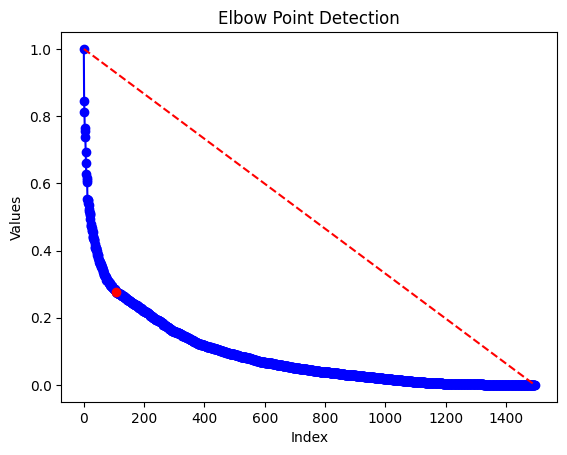

Elbow idx: 108 - Elbow value: 0.26024030538940923


Copying fragments to refined IN-Cluster dir for Reference ID 16:   0%|          | 0/109 [00:00<?, ?it/s]

Iteration 9 out of 26 - Reference ID 17
---------------------------------------------


Creating dataset for Reference 17:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

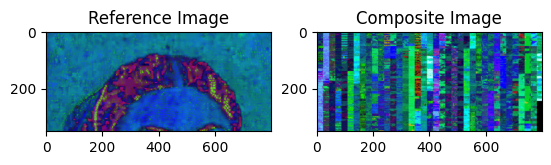

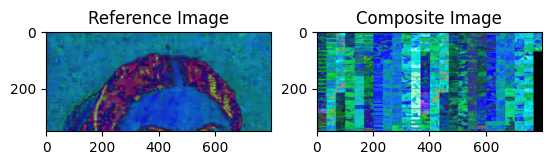

Max distance: 2411.5 - Max N. Matches: 3097
Cluster: cluster_0 - Color Similarity: -0.85 - Distance: 2338.0 - N. Matches: 3097 - Score: -0.20 - Recall: 0.78
Cluster: cluster_1 - Color Similarity: -0.80 - Distance: 2411.5 - N. Matches: 2784 - Score: -0.37 - Recall: 0.22
Recall: 0.78


Refining IN Cluster for Reference ID 17:   0%|          | 0/1504 [00:00<?, ?it/s]

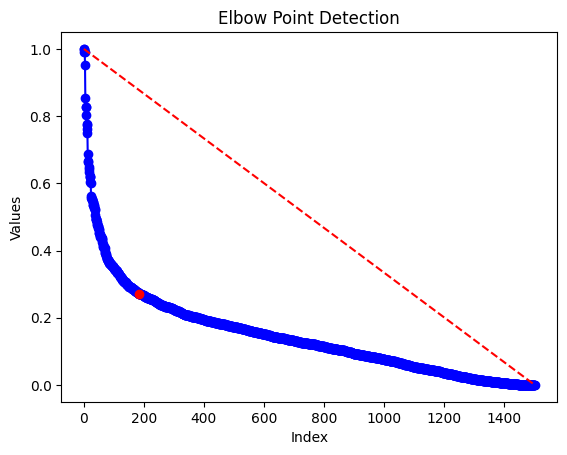

Elbow idx: 183 - Elbow value: 0.27117846959581987


Copying fragments to refined IN-Cluster dir for Reference ID 17:   0%|          | 0/184 [00:00<?, ?it/s]

Iteration 10 out of 26 - Reference ID 18
---------------------------------------------


Creating dataset for Reference 18:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

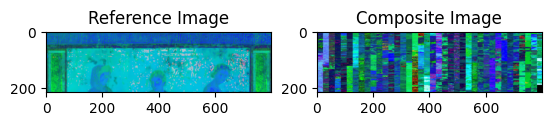

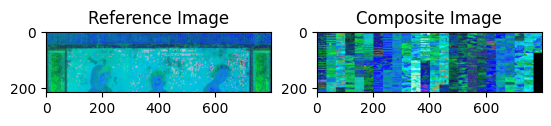

Max distance: 2441.0 - Max N. Matches: 1893
Cluster: cluster_0 - Color Similarity: -0.54 - Distance: 2441.0 - N. Matches: 1893 - Score: -0.06 - Recall: 0.79
Cluster: cluster_1 - Color Similarity: -0.79 - Distance: 2430.0 - N. Matches: 1801 - Score: -0.33 - Recall: 0.21
Recall: 0.79


Refining IN Cluster for Reference ID 18:   0%|          | 0/1477 [00:00<?, ?it/s]

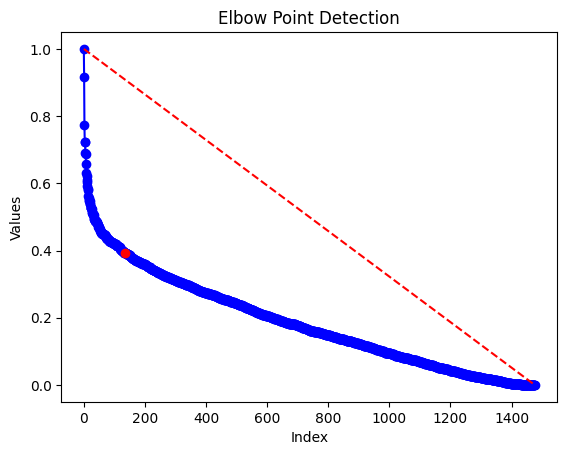

Elbow idx: 134 - Elbow value: 0.39137908498364726


Copying fragments to refined IN-Cluster dir for Reference ID 18:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 11 out of 26 - Reference ID 19
---------------------------------------------


Creating dataset for Reference 19:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

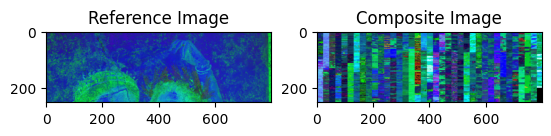

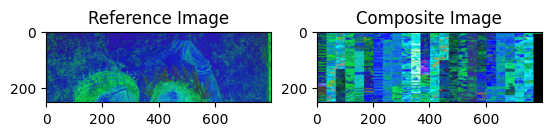

Max distance: 2362.5 - Max N. Matches: 2268
Cluster: cluster_0 - Color Similarity: -0.77 - Distance: 2362.5 - N. Matches: 2268 - Score: -0.17 - Recall: 0.76
Cluster: cluster_1 - Color Similarity: -0.79 - Distance: 2337.5 - N. Matches: 1996 - Score: -0.37 - Recall: 0.24
Recall: 0.76


Refining IN Cluster for Reference ID 19:   0%|          | 0/1508 [00:00<?, ?it/s]

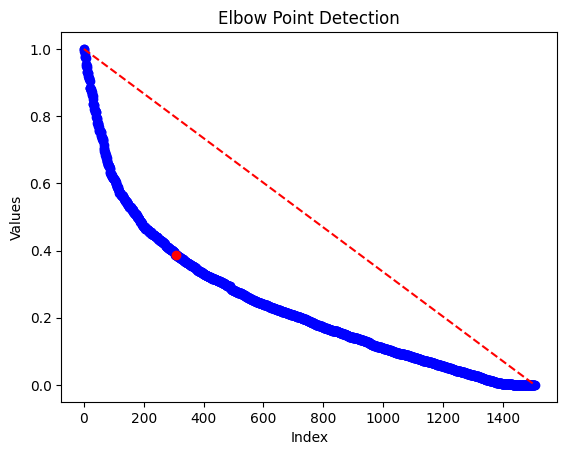

Elbow idx: 307 - Elbow value: 0.38638380435658204


Copying fragments to refined IN-Cluster dir for Reference ID 19:   0%|          | 0/308 [00:00<?, ?it/s]

Iteration 12 out of 26 - Reference ID 2
---------------------------------------------


Creating dataset for Reference 2:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

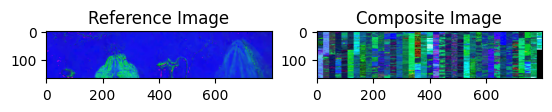

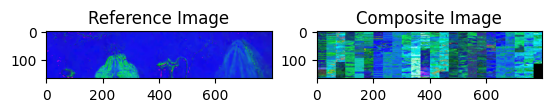

Max distance: 2615.0 - Max N. Matches: 1501
Cluster: cluster_0 - Color Similarity: -0.86 - Distance: 2603.0 - N. Matches: 1501 - Score: -0.21 - Recall: 0.45
Cluster: cluster_1 - Color Similarity: -0.83 - Distance: 2615.0 - N. Matches: 1367 - Score: -0.38 - Recall: 0.55
Recall: 0.45


Refining IN Cluster for Reference ID 2:   0%|          | 0/1492 [00:00<?, ?it/s]

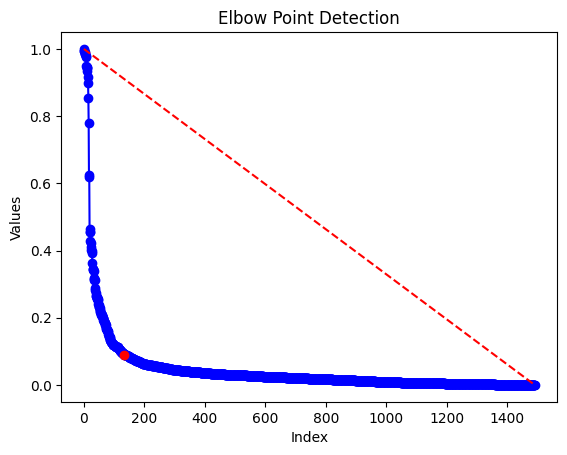

Elbow idx: 134 - Elbow value: 0.09002056553553592


Copying fragments to refined IN-Cluster dir for Reference ID 2:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 13 out of 26 - Reference ID 20
---------------------------------------------


Creating dataset for Reference 20:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

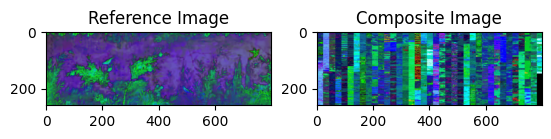

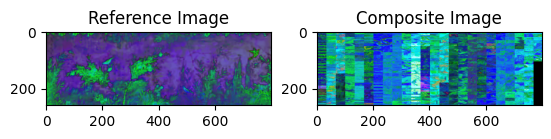

Max distance: 2335.0 - Max N. Matches: 2319
Cluster: cluster_0 - Color Similarity: -0.41 - Distance: 2300.0 - N. Matches: 2319 - Score: 0.02 - Recall: 0.32
Cluster: cluster_1 - Color Similarity: -0.37 - Distance: 2335.0 - N. Matches: 2155 - Score: -0.13 - Recall: 0.68
Recall: 0.32


Refining IN Cluster for Reference ID 20:   0%|          | 0/1499 [00:00<?, ?it/s]

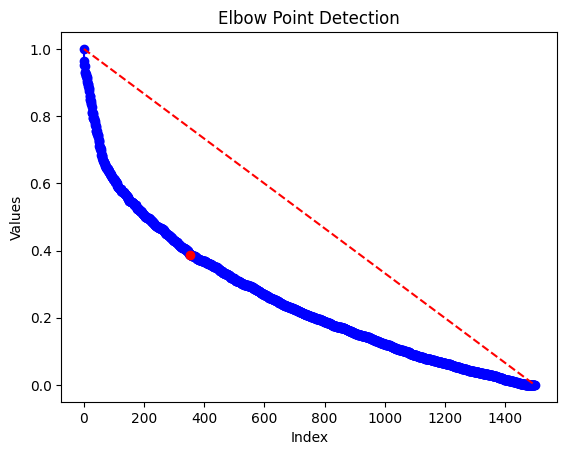

Elbow idx: 354 - Elbow value: 0.22191927786852564


Copying fragments to refined IN-Cluster dir for Reference ID 20:   0%|          | 0/355 [00:00<?, ?it/s]

Iteration 14 out of 26 - Reference ID 21
---------------------------------------------


Creating dataset for Reference 21:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

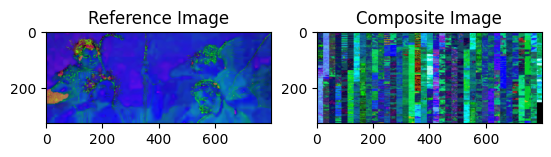

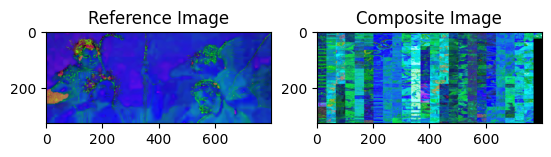

Max distance: 2602.0 - Max N. Matches: 2888
Cluster: cluster_0 - Color Similarity: -0.59 - Distance: 2596.0 - N. Matches: 2888 - Score: -0.08 - Recall: 0.69
Cluster: cluster_1 - Color Similarity: -0.61 - Distance: 2602.0 - N. Matches: 2583 - Score: -0.27 - Recall: 0.31
Recall: 0.69


Refining IN Cluster for Reference ID 21:   0%|          | 0/1507 [00:00<?, ?it/s]

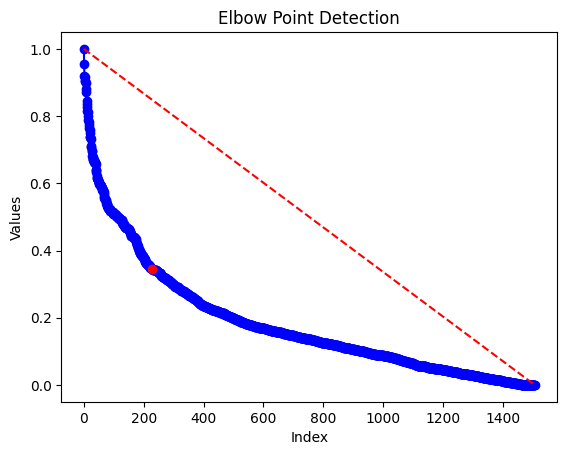

Elbow idx: 229 - Elbow value: 0.33463337426372874


Copying fragments to refined IN-Cluster dir for Reference ID 21:   0%|          | 0/230 [00:00<?, ?it/s]

Iteration 15 out of 26 - Reference ID 22
---------------------------------------------


Creating dataset for Reference 22:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

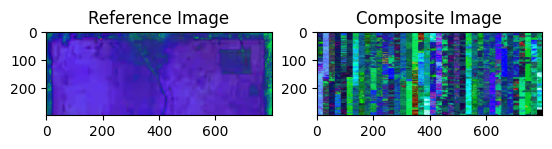

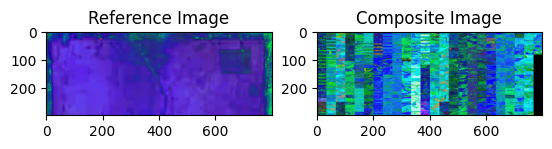

Max distance: 2690.0 - Max N. Matches: 2568
Cluster: cluster_0 - Color Similarity: -0.54 - Distance: 2677.5 - N. Matches: 2568 - Score: -0.05 - Recall: 0.78
Cluster: cluster_1 - Color Similarity: -0.54 - Distance: 2690.0 - N. Matches: 2378 - Score: -0.22 - Recall: 0.23
Recall: 0.78


Refining IN Cluster for Reference ID 22:   0%|          | 0/1479 [00:00<?, ?it/s]

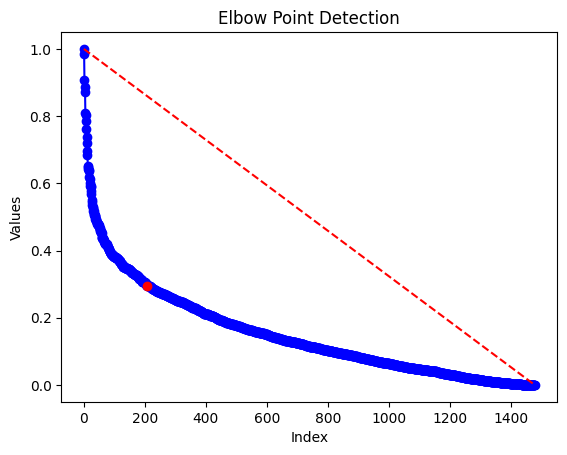

Elbow idx: 208 - Elbow value: 0.1454368384855996


Copying fragments to refined IN-Cluster dir for Reference ID 22:   0%|          | 0/209 [00:00<?, ?it/s]

Iteration 16 out of 26 - Reference ID 23
---------------------------------------------


Creating dataset for Reference 23:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

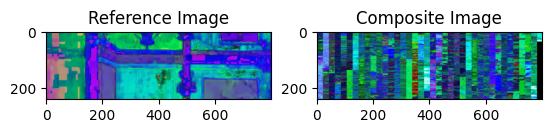

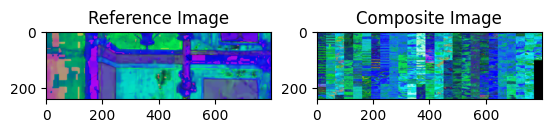

Max distance: 2468.0 - Max N. Matches: 2035
Cluster: cluster_0 - Color Similarity: 0.46 - Distance: 2388.0 - N. Matches: 2035 - Score: 0.45 - Recall: 0.97
Cluster: cluster_1 - Color Similarity: -0.23 - Distance: 2468.0 - N. Matches: 1851 - Score: -0.07 - Recall: 0.03
Recall: 0.97


Refining IN Cluster for Reference ID 23:   0%|          | 0/1449 [00:00<?, ?it/s]

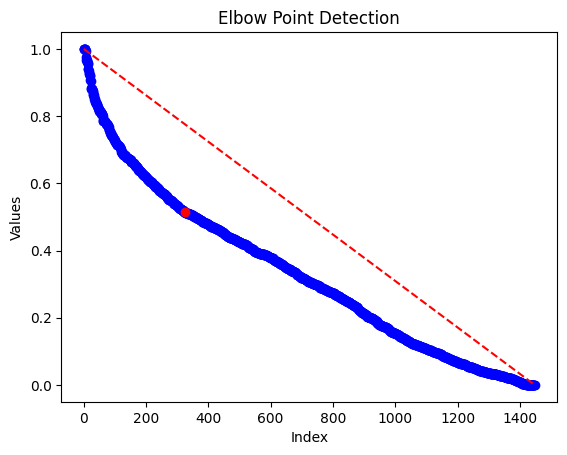

Elbow idx: 324 - Elbow value: 0.5133787433338988


Copying fragments to refined IN-Cluster dir for Reference ID 23:   0%|          | 0/325 [00:00<?, ?it/s]

Iteration 17 out of 26 - Reference ID 24
---------------------------------------------


Creating dataset for Reference 24:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

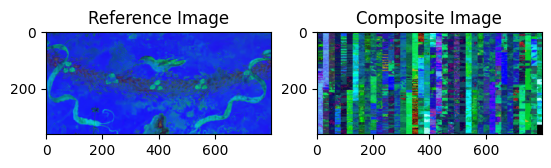

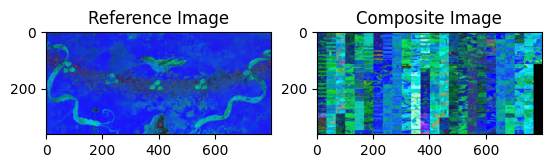

Max distance: 2434.0 - Max N. Matches: 3267
Cluster: cluster_0 - Color Similarity: -0.74 - Distance: 2416.0 - N. Matches: 3267 - Score: -0.16 - Recall: 0.24
Cluster: cluster_1 - Color Similarity: -0.83 - Distance: 2434.0 - N. Matches: 2882 - Score: -0.39 - Recall: 0.76
Recall: 0.24


Refining IN Cluster for Reference ID 24:   0%|          | 0/1478 [00:00<?, ?it/s]

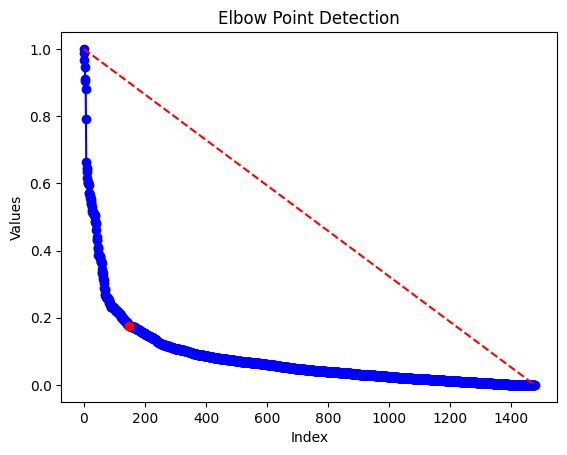

Elbow idx: 149 - Elbow value: 0.16535921020302316


Copying fragments to refined IN-Cluster dir for Reference ID 24:   0%|          | 0/150 [00:00<?, ?it/s]

Iteration 18 out of 26 - Reference ID 25
---------------------------------------------


Creating dataset for Reference 25:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

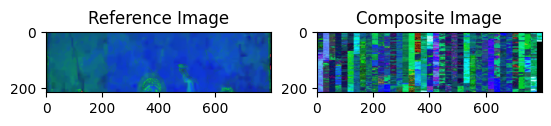

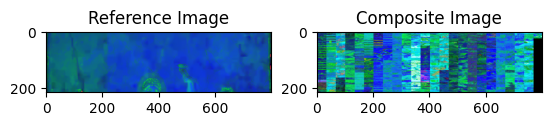

Max distance: 3074.0 - Max N. Matches: 1879
Cluster: cluster_0 - Color Similarity: -0.91 - Distance: 3053.0 - N. Matches: 1879 - Score: -0.24 - Recall: 1.00
Cluster: cluster_1 - Color Similarity: -0.89 - Distance: 3074.0 - N. Matches: 1778 - Score: -0.38 - Recall: 0.00
Recall: 1.00


Refining IN Cluster for Reference ID 25:   0%|          | 0/1483 [00:00<?, ?it/s]

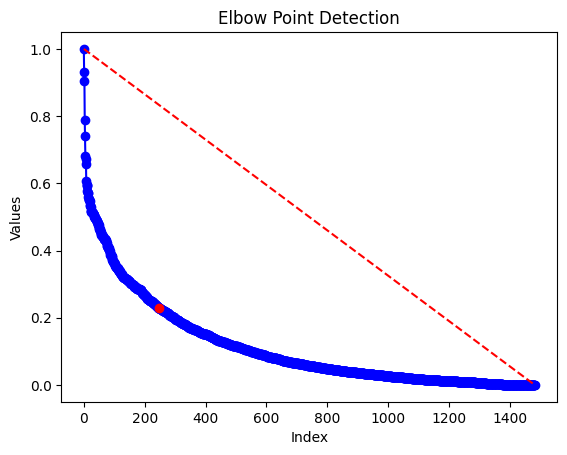

Elbow idx: 247 - Elbow value: 0.21365298793259113


Copying fragments to refined IN-Cluster dir for Reference ID 25:   0%|          | 0/248 [00:00<?, ?it/s]

Iteration 19 out of 26 - Reference ID 26
---------------------------------------------


Creating dataset for Reference 26:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

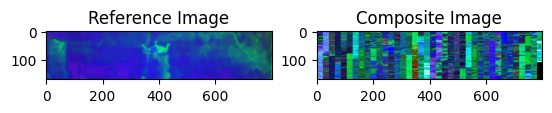

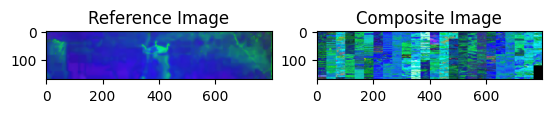

Max distance: 3182.0 - Max N. Matches: 1477
Cluster: cluster_0 - Color Similarity: -0.81 - Distance: 3056.0 - N. Matches: 1477 - Score: -0.17 - Recall: 1.00
Cluster: cluster_1 - Color Similarity: -0.66 - Distance: 3182.0 - N. Matches: 1399 - Score: -0.27 - Recall: 0.00
Recall: 1.00


Refining IN Cluster for Reference ID 26:   0%|          | 0/1468 [00:00<?, ?it/s]

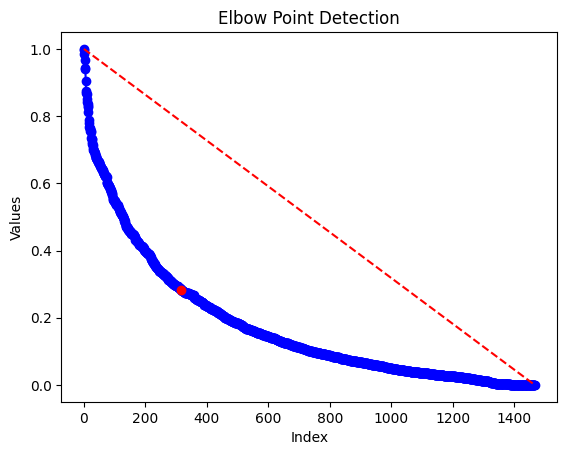

Elbow idx: 316 - Elbow value: 0.28246455793980146


Copying fragments to refined IN-Cluster dir for Reference ID 26:   0%|          | 0/317 [00:00<?, ?it/s]

Iteration 20 out of 26 - Reference ID 3
---------------------------------------------


Creating dataset for Reference 3:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

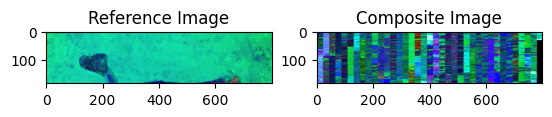

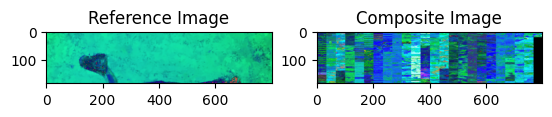

Max distance: 2604.0 - Max N. Matches: 1609
Cluster: cluster_0 - Color Similarity: -0.82 - Distance: 2552.0 - N. Matches: 1609 - Score: -0.19 - Recall: 1.00
Cluster: cluster_1 - Color Similarity: -0.92 - Distance: 2604.0 - N. Matches: 1478 - Score: -0.41 - Recall: 0.00
Recall: 1.00


Refining IN Cluster for Reference ID 3:   0%|          | 0/1483 [00:00<?, ?it/s]

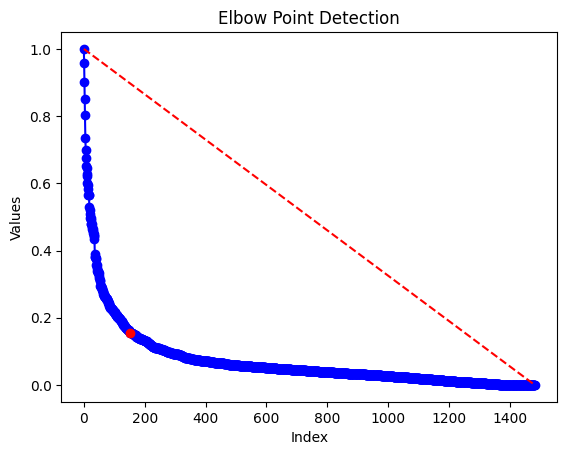

Elbow idx: 153 - Elbow value: 0.11913263473511419


Copying fragments to refined IN-Cluster dir for Reference ID 3:   0%|          | 0/154 [00:00<?, ?it/s]

Iteration 21 out of 26 - Reference ID 4
---------------------------------------------


Creating dataset for Reference 4:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

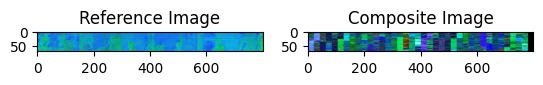

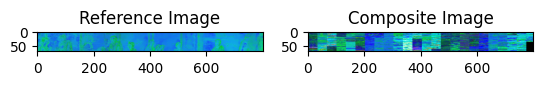

Max distance: 3232.0 - Max N. Matches: 501
Cluster: cluster_0 - Color Similarity: -0.51 - Distance: 3232.0 - N. Matches: 501 - Score: -0.04 - Recall: 0.01
Cluster: cluster_1 - Color Similarity: -0.58 - Distance: 3176.0 - N. Matches: 494 - Score: -0.21 - Recall: 0.99
Recall: 0.01


Refining IN Cluster for Reference ID 4:   0%|          | 0/1519 [00:00<?, ?it/s]

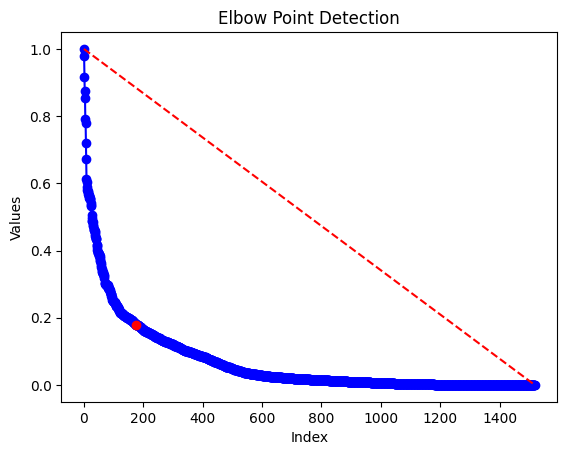

Elbow idx: 175 - Elbow value: 0.16665844603460167


Copying fragments to refined IN-Cluster dir for Reference ID 4:   0%|          | 0/176 [00:00<?, ?it/s]

Iteration 22 out of 26 - Reference ID 5
---------------------------------------------


Creating dataset for Reference 5:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

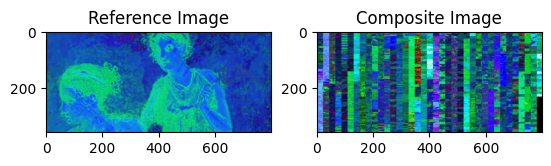

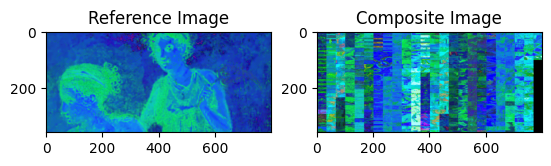

Max distance: 2440.0 - Max N. Matches: 3193
Cluster: cluster_0 - Color Similarity: -0.63 - Distance: 2422.0 - N. Matches: 3193 - Score: -0.09 - Recall: 0.78
Cluster: cluster_1 - Color Similarity: -0.79 - Distance: 2440.0 - N. Matches: 2902 - Score: -0.36 - Recall: 0.22
Recall: 0.78


Refining IN Cluster for Reference ID 5:   0%|          | 0/1502 [00:00<?, ?it/s]

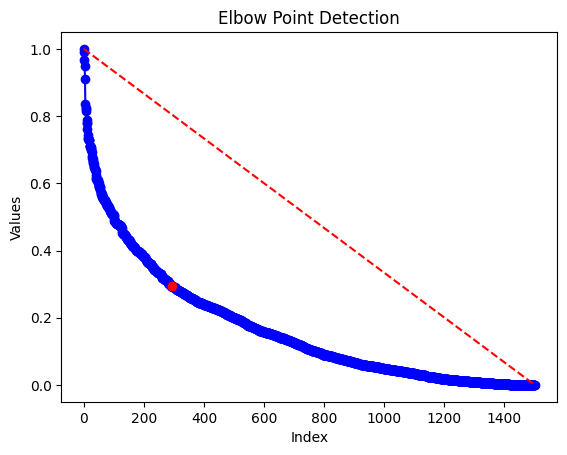

Elbow idx: 292 - Elbow value: 0.29369520973628715


Copying fragments to refined IN-Cluster dir for Reference ID 5:   0%|          | 0/293 [00:00<?, ?it/s]

Iteration 23 out of 26 - Reference ID 6
---------------------------------------------


Creating dataset for Reference 6:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

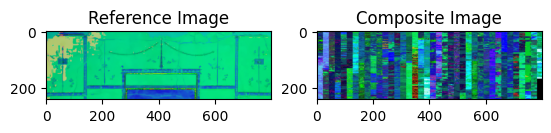

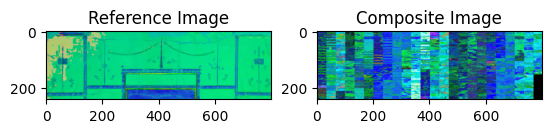

Max distance: 2470.0 - Max N. Matches: 2191
Cluster: cluster_0 - Color Similarity: -0.75 - Distance: 2470.0 - N. Matches: 2191 - Score: -0.16 - Recall: 0.97
Cluster: cluster_1 - Color Similarity: -0.88 - Distance: 2455.0 - N. Matches: 1997 - Score: -0.39 - Recall: 0.03
Recall: 0.97


Refining IN Cluster for Reference ID 6:   0%|          | 0/1470 [00:00<?, ?it/s]

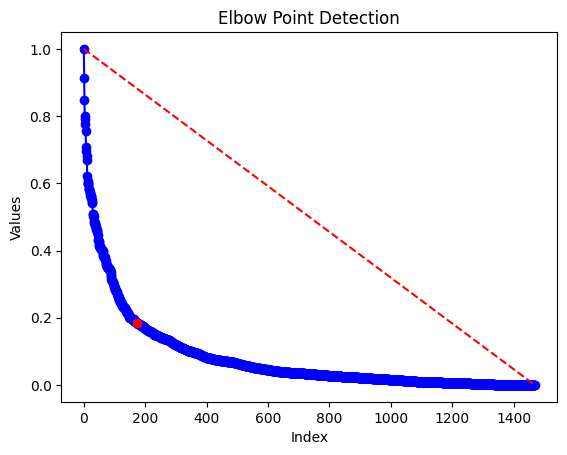

Elbow idx: 173 - Elbow value: 0.17227194319172998


Copying fragments to refined IN-Cluster dir for Reference ID 6:   0%|          | 0/174 [00:00<?, ?it/s]

Iteration 24 out of 26 - Reference ID 7
---------------------------------------------


Creating dataset for Reference 7:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

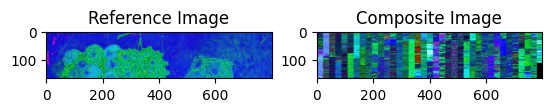

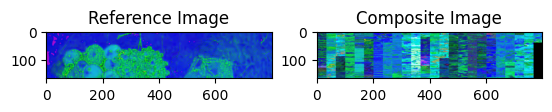

Max distance: 2487.0 - Max N. Matches: 1437
Cluster: cluster_0 - Color Similarity: -0.59 - Distance: 2487.0 - N. Matches: 1437 - Score: -0.08 - Recall: 0.33
Cluster: cluster_1 - Color Similarity: -0.78 - Distance: 2485.0 - N. Matches: 1321 - Score: -0.35 - Recall: 0.67
Recall: 0.33


Refining IN Cluster for Reference ID 7:   0%|          | 0/1503 [00:00<?, ?it/s]

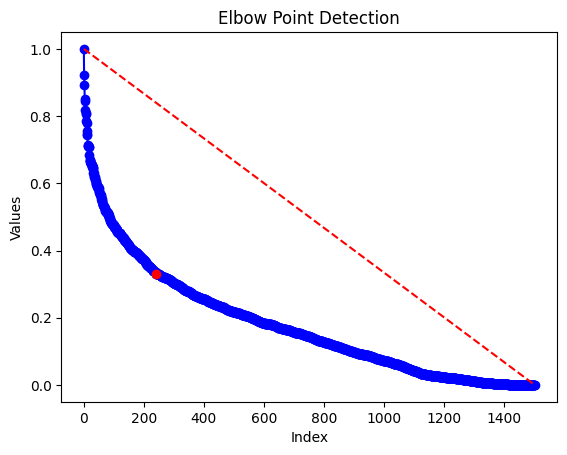

Elbow idx: 241 - Elbow value: 0.2266045798361585


Copying fragments to refined IN-Cluster dir for Reference ID 7:   0%|          | 0/242 [00:00<?, ?it/s]

Iteration 25 out of 26 - Reference ID 8
---------------------------------------------


Creating dataset for Reference 8:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

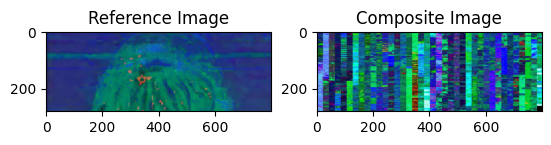

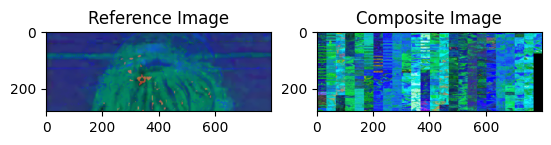

Max distance: 2882.0 - Max N. Matches: 2527
Cluster: cluster_0 - Color Similarity: -0.72 - Distance: 2882.0 - N. Matches: 2527 - Score: -0.14 - Recall: 1.00
Cluster: cluster_1 - Color Similarity: -0.87 - Distance: 2830.0 - N. Matches: 2259 - Score: -0.39 - Recall: 0.00
Recall: 1.00


Refining IN Cluster for Reference ID 8:   0%|          | 0/1479 [00:00<?, ?it/s]

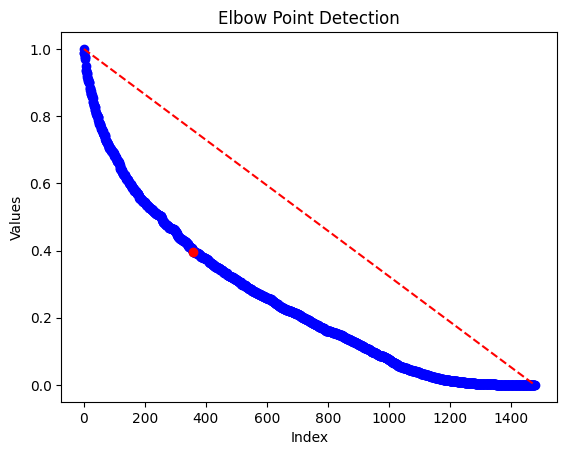

Elbow idx: 359 - Elbow value: 0.2523955105901652


Copying fragments to refined IN-Cluster dir for Reference ID 8:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration 26 out of 26 - Reference ID 9
---------------------------------------------


Creating dataset for Reference 9:   0%|          | 0/2084 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2084 [00:00<?, ?it/s]

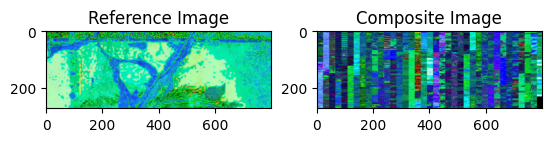

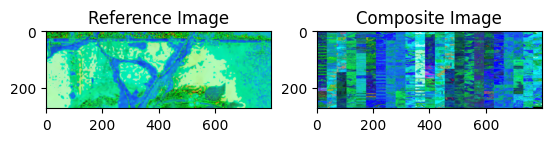

Max distance: 2314.0 - Max N. Matches: 2467
Cluster: cluster_0 - Color Similarity: -0.28 - Distance: 2314.0 - N. Matches: 2467 - Score: 0.08 - Recall: 0.40
Cluster: cluster_1 - Color Similarity: -0.75 - Distance: 2304.5 - N. Matches: 2244 - Score: -0.34 - Recall: 0.60
Recall: 0.40


Refining IN Cluster for Reference ID 9:   0%|          | 0/1510 [00:00<?, ?it/s]

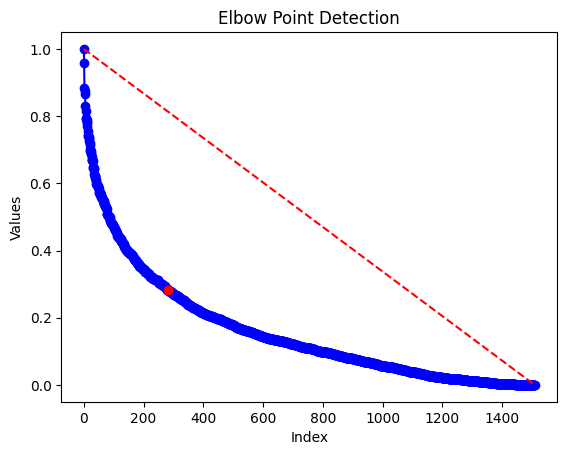

Elbow idx: 281 - Elbow value: 0.21919753695893707


Copying fragments to refined IN-Cluster dir for Reference ID 9:   0%|          | 0/282 [00:00<?, ?it/s]



Terminated!


Correct IN cluster selected: 19/26 --- 73.08%


In [112]:
n_references = len(references_ids)
correct_IN_clusters = 0

metrics = {}

for i in range(n_references):
    reference_id = references_ids[i]
    reference_image = references[i]

    print(f"Iteration {i + 1} out of {n_references} - Reference ID {reference_id}")
    print("---------------------------------------------")

    reference_color_histogram = cv.calcHist([reference_image], [0, 1, 2], None, (8, 8, 8), [0, 256, 0, 256, 0, 256])
    cv.normalize(reference_color_histogram, reference_color_histogram, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

    # extract region working region and convert to grayscale 
    reference_image_bgr = cv.cvtColor(reference_image, cv.COLOR_HSV2BGR)
    reference_image_gray = cv.cvtColor(reference_image, cv.COLOR_BGR2GRAY)
    # extract reference texture features starting from the borders and normalize them 
    reference_texture_features = compute_feats(reference_image_gray, kernels)
    normalized_reference_texture_features = minmax_norm(reference_texture_features)

    X = []
    for _ in tqdm(range(n_fragments), desc=f"Creating dataset for Reference {reference_id}", total=n_fragments): 
        fragment_reference_color_intersection = cv.compareHist(reference_color_histogram, color_histograms[_], cv.HISTCMP_INTERSECT) / np.sum(color_histograms[_])
        X.append(np.hstack((fragment_reference_color_intersection, normalized_feats[_].reshape(-1), 
                            np.multiply(normalized_reference_texture_features, normalized_feats[_]).reshape(-1)))) # texture intersection between referen
        
    X = np.array(X)

    kmeans = KMeans(n_clusters=2, random_state=seed, n_init="auto")
    fit_kmeans = kmeans.fit(X)

    create_cluster_dirs(fragments_paths, output_dir=output_dir, labels=fit_kmeans.labels_)
    IN_cluster, correct_IN_cluster, IN_cluster_recall, correct_IN_cluster_recall = choose_IN_cluster(reference_image, reference_id, 
                                                                                                     output_dir, fragments, fragments_reading_order, 
                                                                                                     image_size, color_weights, choice_weights)
    if IN_cluster == correct_IN_cluster:
        correct_IN_clusters += 1
    
    IN_cluster_path = os.path.join(output_dir, IN_cluster)

    IN_cluster_fragments_names = [filename for filename in os.listdir(IN_cluster_path)]
    IN_cluster_indexes = [fragments_reading_order[filename] for filename in IN_cluster_fragments_names]
    IN_cluster_fragments = fragments[IN_cluster_indexes] 
       
    print(f"Recall: {recall_in_out_clusters(reference_id, output_dir, [IN_cluster]):.2f}")

    # refine IN Cluster
    n_IN_fragments = len(IN_cluster_fragments)
    IN_color_histograms = color_histograms[IN_cluster_indexes]
    fragment_color_map = {}
    IN_color_intersections = []
    
    for _ in tqdm(range(n_IN_fragments), desc=f"Refining IN Cluster for Reference ID {reference_id}", total=n_IN_fragments): 
        fragment_reference_color_intersection = cv.compareHist(reference_color_histogram, IN_color_histograms[_], cv.HISTCMP_INTERSECT) / np.sum(IN_color_histograms[_])
        IN_color_intersections.append(fragment_reference_color_intersection)
        fragment_color_map[IN_cluster_fragments_names[_]] = fragment_reference_color_intersection
    
    IN_color_intersections = np.array(IN_color_intersections)
    IN_color_intersections = np.sort(IN_color_intersections)[::-1] # sort in descending order
    fragment_color_map_sorted = dict(sorted(fragment_color_map.items(), key=lambda x: x[1], reverse=True))
    
    idx, value = find_elbow_point(IN_color_intersections) 
    refined_filenames = list(fragment_color_map_sorted.keys())[:idx+1]
    # copy fragments and create refined IN-cluster dir 
    refined_IN_cluster_path = os.path.join(in_clusters_dir, str(reference_id))
    
    if os.path.exists(refined_IN_cluster_path):
        shutil.rmtree(refined_IN_cluster_path)
    os.makedirs(refined_IN_cluster_path, exist_ok=True)
    
    for filename in tqdm(refined_filenames, desc=f"Copying fragments to refined IN-Cluster dir for Reference ID {reference_id}", total=len(refined_filenames)):
        shutil.copy(os.path.join(IN_cluster_path, filename), os.path.join(refined_IN_cluster_path, filename))

     # compute pre-refining metrics
    metrics[reference_id] = {
        "pre_refinement_precision": precision(reference_id, IN_cluster_path),
        "pre_refinement_recall": recall_in_out_clusters(reference_id, output_dir, [IN_cluster]),
        "pre_refinement_number_of_fragments": len(IN_cluster_fragments), 
        "post_refinement_precision": precision(reference_id, refined_IN_cluster_path),
        "post_refinement_recall": recall_in_cluster(reference_id, refined_IN_cluster_path, fragments_dir),
        "post_refinement_number_of_fragments": len(refined_filenames), 
        "reduction": 1 - (len(refined_filenames) / len(IN_cluster_fragments))
    }

correct_guesses = correct_IN_clusters / n_references 

print("\n\nTerminated!\n\n")
print(f"Correct IN cluster selected: {correct_IN_clusters}/{n_references } --- {(correct_guesses) * 100:.2f}%")

In [113]:
with open("metrics.json", "w") as f:
    json.dump(metrics, f)